In [1]:
import sys
sys.path.append('..')

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.pyplot import imshow
from tqdm import tqdm
import torch
from torch.nn import Module
from torchsummary import summary
from pycocotools import mask as coco_mask_util

from collections import namedtuple, defaultdict
from pathlib import Path
import time

%matplotlib inline
rcParams['figure.figsize'] = (10, 15)

In [3]:
from src.constructor.config_structure import TrainConfigParams
from src.registry import TASKS
from src.constructor.data import create_dataset
from src.constructor.trainer import download_s3_artifact
from train import load_config

In [4]:
def load_hparams(config_path):
    hparams = load_config(config_path)
    hparams = TrainConfigParams(**hparams)
    
    return hparams

In [5]:
config_path = '../configs/leaves_hrnet_w18_manual.yml'
config = load_hparams(config_path)

In [6]:
data_params = config.data
common_params = data_params.common_params
# other_params = data_params.train_params
other_params = data_params.valid_params
# other_params = data_params.test_params
dataset_name = other_params.name

dataset = create_dataset(dataset_name, common_params, other_params)

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [8]:
# checkpoint = torch.load(download_s3_artifact('s3://ml-fips/mlruns/eedfa4c178bd44f8bc6c44cdcc0f4814/artifacts/last.ckpt', '/tmp'), map_location=device)
# checkpoint = torch.load("/workdir/logs/comp-vladvin/2021-11-20_08-25-09/11-311.ckpt")
# checkpoint = torch.load("/workdir/logs/comp-vladvin/2021-11-20_19-47-29/10-1121.ckpt")
checkpoint = torch.load("/workdir/logs/comp-vladvin/2021-11-21_05-01-01/last.ckpt")
# checkpoint = torch.load("/workdir/logs/comp-vladvin/2021-11-21_06-02-26/239-239.ckpt")
model = TASKS.get(config.task.name)(config)
model = model.to(device)
model.load_state_dict(checkpoint['state_dict'])
model.eval();
# model.half();

Pretrained weights for hrnet_w18_small will be downloaded


In [12]:
CKPT_PATH = '/workdir/strawberry_hack/checkpoints/leaves_hrnet_w18_small_manual.pt'
HEIGHT, WIDTH = 800, 800

In [13]:
# traced = torch.jit.trace(model.forward, torch.rand(2, 3, HEIGHT, WIDTH, device=device))
# traced.save(CKPT_PATH)

## Inference

In [14]:
model = torch.jit.load(CKPT_PATH, map_location=device)

In [15]:
from torchvision.transforms import ToTensor, Normalize, Compose

TRANSFORMS = Compose([
    ToTensor(),
    Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

def longest_max_size(img, max_size=1000):
    if img.shape[0] > img.shape[1]:
        new_h, new_w = max_size, int(max_size / img.shape[0] * img.shape[1])
    else:
        new_h, new_w = int(max_size / img.shape[1] * img.shape[0]), max_size

    img = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_LINEAR)
    
    return img

def pad_if_needed(img, max_size=1000):
    top = max(0, (max_size - img.shape[0]) // 2)
    bottom = max(0, max_size - img.shape[0] - top)
    left = max(0, (max_size - img.shape[1]) // 2)
    right = max(0, max_size - img.shape[1] - left)
    img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT)
    
    return img, top, bottom, left, right

def preprocess(img, max_size=1000):
    img = longest_max_size(img, max_size)
    img, top, bottom, left, right = pad_if_needed(img, max_size)
    tensor = TRANSFORMS(img)
    
    return tensor, top, bottom, left, right

In [21]:
def infer(img):
    tensor, top, bottom, left, right = preprocess(img, max_size=max(HEIGHT, WIDTH))
    
    with torch.no_grad():
        output = model.forward(tensor.to(device).unsqueeze(0)).squeeze(0)
        pred = output.argmax(0)
#         pred = torch.sigmoid(output)
#         pred = pred > 0.5
#         pred = (pred * 255).cpu().numpy().astype(np.uint8)
        pred = pred.cpu().numpy().astype(np.uint8)
        
    pred = pred[top:, left:]
    if bottom > 0:
        pred = pred[:-bottom, :]
    if right > 0:
        pred = pred[:, :-right]
        
    return pred, output

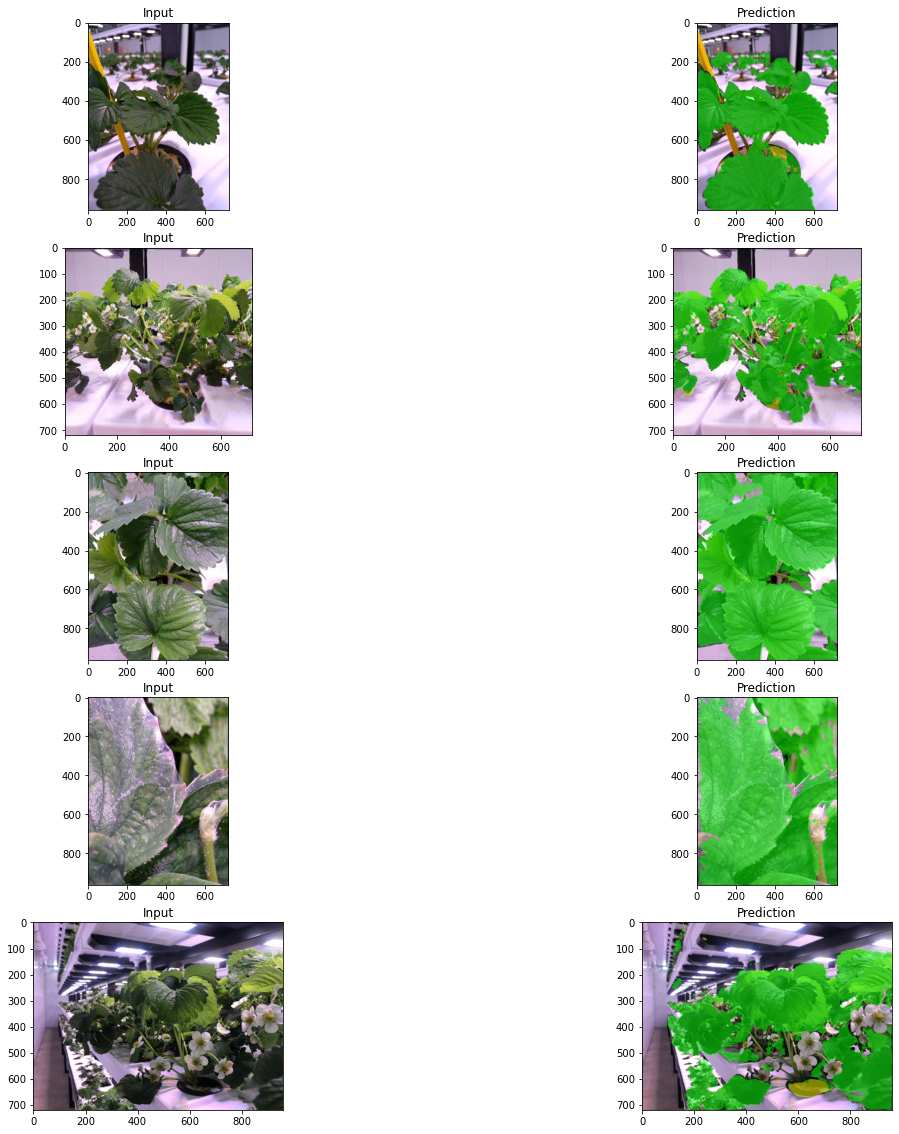

In [17]:
start_idx = 235
n_imgs = 5
fig, axs = plt.subplots(n_imgs, 2, figsize=(20, 4 * n_imgs))

results = []
for i in range(n_imgs):
# for i, idx in enumerate([48, 65, 60]):
    # Here image is RGB !!!
    img = dataset.read_image(dataset.csv.iloc[start_idx + i])
    mask = dataset.read_mask(dataset.csv.iloc[start_idx + i]['mask_path'])
#     img = dataset.read_image(dataset.csv.iloc[idx])
#     mask = dataset.read_mask(dataset.csv.iloc[idx]['mask_path'])
    
    pred, _ = infer(img)
        
    # Resize mask to initial size
    pred = cv2.resize(pred, img.shape[:2][::-1], interpolation=cv2.INTER_NEAREST)
    overlay = img.copy()
    overlay[pred == 1] = [0, 255, 0]
    overlay[pred == 2] = [255, 255, 0]
    res = cv2.addWeighted(img, 0.5, overlay, 0.5, 1.)
    
    overlay = img.copy()
    overlay[mask > 0] = [255, 0, 0]
    mask = cv2.addWeighted(img, 0.5, overlay, 0.5, 1.)
    
    axs[i][0].imshow(img)
    axs[i][0].set_title('Input')
    
    results.append(res)
    axs[i][1].imshow(res)
    axs[i][1].set_title('Prediction')
    
#     axs[i][2].imshow(mask)
#     axs[i][2].set_title('GT')

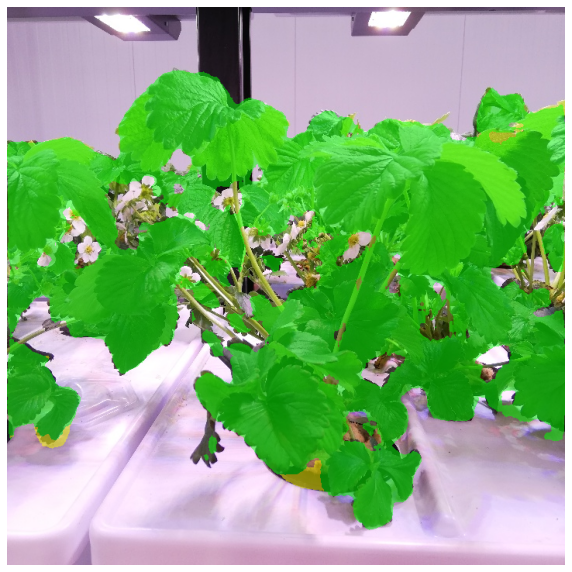

In [18]:
imshow(results[1]);
plt.axis('off');

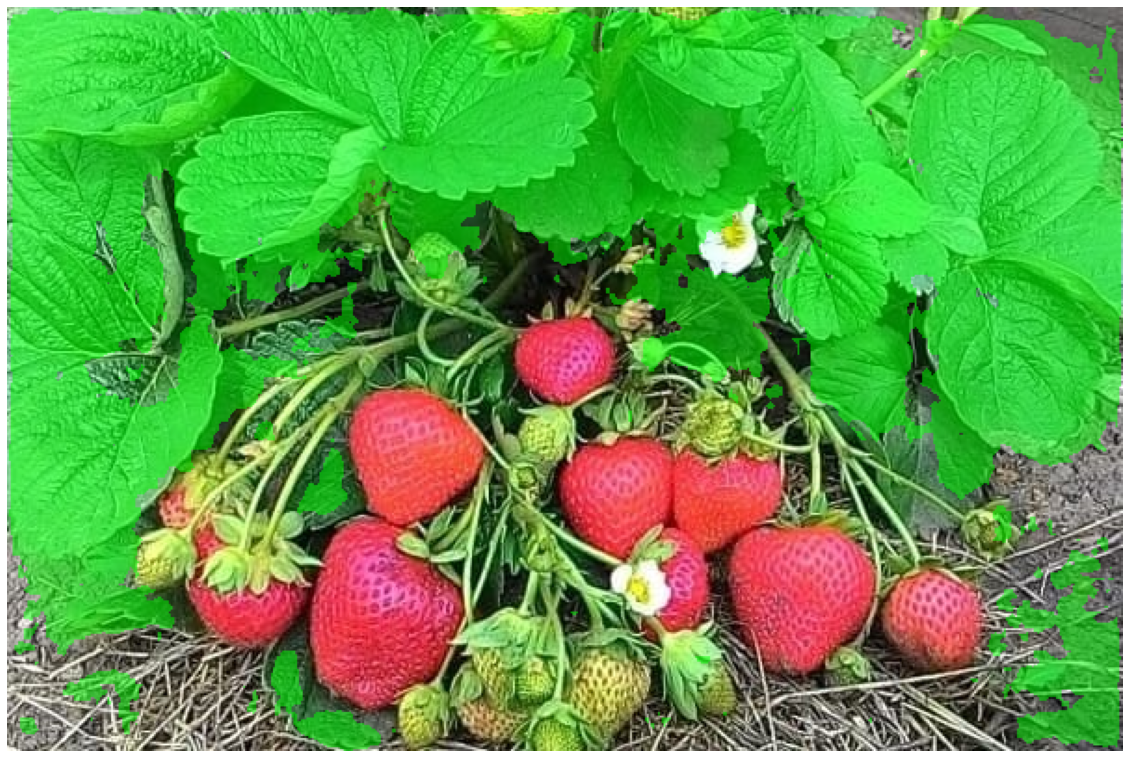

In [54]:
img = cv2.imread("test/photo_2021-11-24_09-58-09.jpg")[..., ::-1]
pred, output = infer(img)
# Resize mask to initial size
pred = cv2.resize(pred, img.shape[:2][::-1], interpolation=cv2.INTER_NEAREST)
overlay = img.copy()
overlay[pred > 0] = [0, 255, 0]
res = cv2.addWeighted(img, 0.5, overlay, 0.5, 1.)
cv2.imwrite("tmp.jpg", res[..., ::-1])
plt.figure(figsize=(20, 20))
imshow(res);
plt.axis('off');

In [20]:
def coco_rle_encode(mask, classidx2name):
    n_classes = len(classidx2name)
    rles = []
    for cl_idx in range(1, n_classes):
        bimask = mask == cl_idx
        coco_enc = coco_mask_util.encode(np.asfortranarray(bimask.astype(np.uint8)))
        coco_enc.update({'class': classidx2name[cl_idx]})
        coco_enc['counts'] = coco_enc['counts'].decode('utf-8')
        rles.append(coco_enc)

    return rles


def coco_rle_decode(rles):
    if not rles:
        return None

    masks = []
    for rle in rles:
        mask = coco_mask_util.decode(rle)
        masks.append(mask)

    h, w = masks[0].shape
    mask = np.zeros((h, w), dtype=np.uint8)
    for cl_idx, mask_ch in enumerate(masks):
        mask[mask_ch > 0] = cl_idx + 1

    return mask

In [18]:
CLASS_MAP = {
    0: "Background",
    1: "Leaf",
    2: "Cell"
}

In [ ]:
rle = coco_rle_encode(pred, CLASS_MAP)
rle

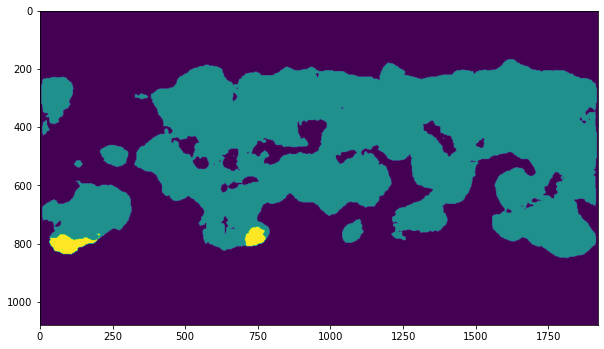

In [20]:
mask = coco_rle_decode(rle)
imshow(mask);